In [1]:
import data_processing
import numpy as np
import matplotlib.pyplot as plt
import config

In [2]:
print(config.EPOCHS)

100


In [3]:
X, y = data_processing.load_images('data/train')
print(X.shape)
print(y.shape)

(467, 105, 105)
(467,)


In [4]:
(X_train, y_train) = data_processing.make_pairs(X, y)

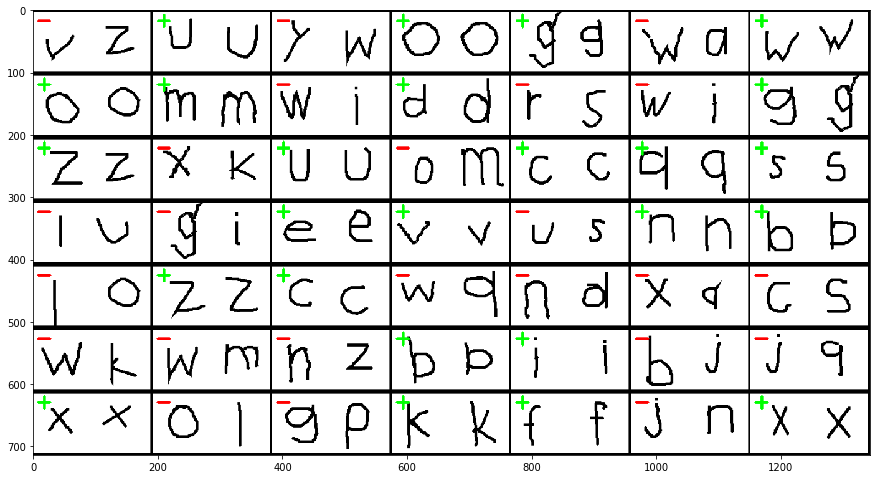

In [5]:
data_processing.pairs_montage(X_train, y_train)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Lambda, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2

In [7]:
def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [8]:
def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [9]:
def build_siamese_model(input_shape):

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights, bias_initializer=initialize_bias))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid')(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

    # return the model
    return siamese_net

In [10]:
model = build_siamese_model(config.IMG_SHAPE)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[1][0]             

In [11]:
optimizer = Adam(lr=config.LEARNING_RATE)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

In [12]:
trainX = np.expand_dims(X, axis=-1)
(X_train, y_train) = data_processing.make_pairs(trainX, y)

In [13]:
history = model.fit(
	[X_train[:, 0], X_train[:, 1]], y_train[:],
	validation_split=0.1,
	batch_size=config.BATCH_SIZE, 
	epochs=config.EPOCHS,
	verbose=0)

In [14]:
model.save(config.MODEL_PATH)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/siamese_model/assets


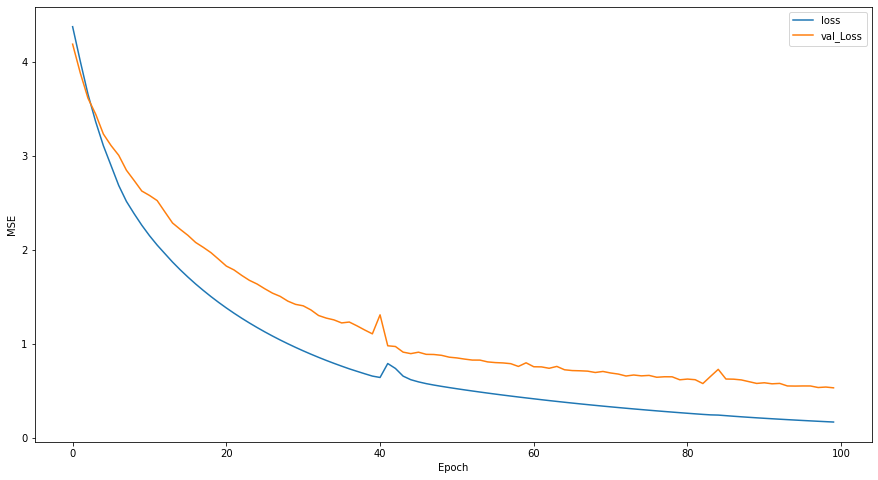

In [15]:
plt.figure(figsize=(15,8))

plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.plot(model.history.history['loss'][:], label='loss')
plt.plot(model.history.history['val_loss'][:], label='val_Loss')
plt.legend()

In [16]:
tf.keras.backend.clear_session()

data/test/samples/q.png


/tf/siamese-NN/data_processing.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(4, 6))


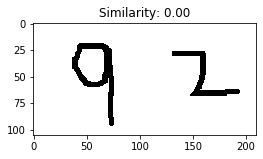

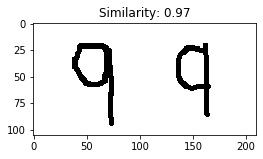

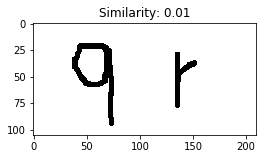

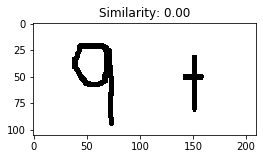

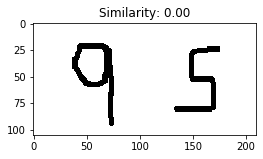

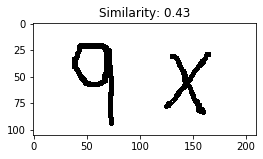

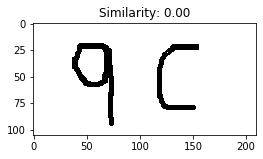

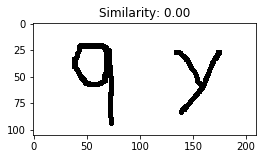

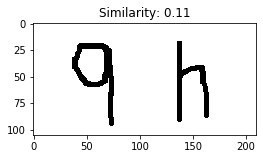

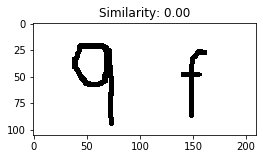

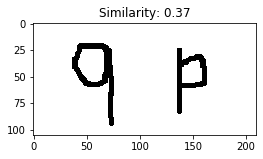

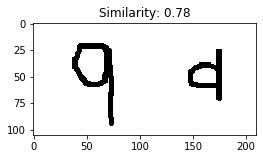

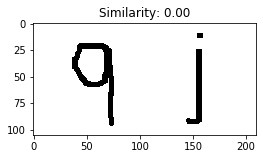

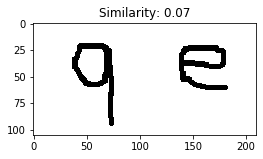

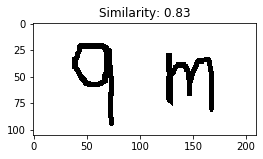

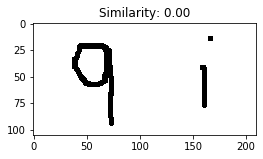

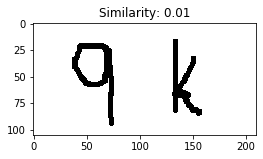

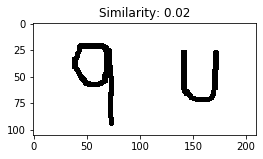

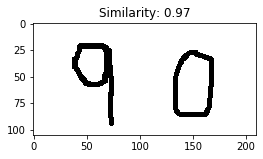

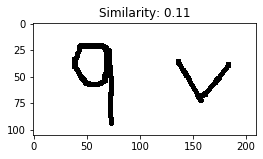

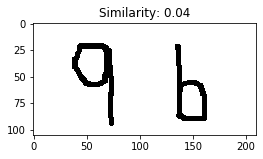

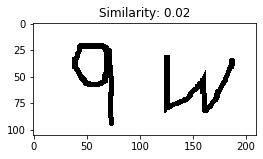

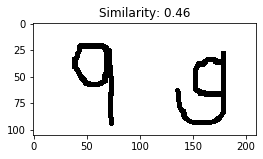

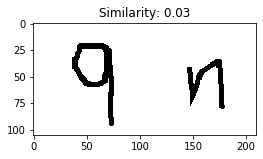

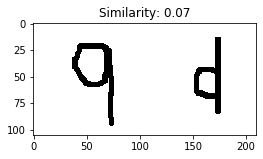

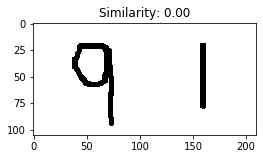

In [17]:
sample_name = config.TEST_SAMPLES + 'q.png'
print(sample_name)
data_processing.evaluate_data(model, config.TEST_CLASSES, sample_name,)